In [ ]:
# Notes for tomorrow
# Explore if CEEMDAN has data leakage by doing 
# a windowed approach and comparing that to CEEMDAN on the entire dataset
# if there is no leakage then it shouldn't matter that we decompose the entire series before splitting
# this would have implications on 00.1 notebook where we split the series before doing CEEMDAN
# 
# regardless we should investigate the advanced splitting because I believe I have only shrunk the data currently.


# Investigating CEEMDAN and Normalization Effects on Data

In [1]:
import pandas as pd
import numpy as np
import pickle
from datetime import timedelta, datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, minmax_scale
from PyEMD import CEEMDAN, Visualisation
from sklearn.decomposition import PCA
import plotly.express as px
from tqdm import tqdm
from datetime import datetime
import sys, os

In [2]:
absolutepath = os.path.abspath('')
fileDirectory = os.path.dirname(absolutepath)

#Path of parent directory (moves outside of repository)
parentDirectory = os.path.dirname(fileDirectory)

In [3]:
# setting variables for importing data
coi = ['ticker','reportperiod','Open','High','Low','Close','Volume']
dfile='/data/raw_data_2021-11-12_12.31.45.pkl'
tick='MSFT' 
annum=2020

In [4]:
# grab only the data needed
ticker_dataframe = pd.read_pickle(fileDirectory+ dfile)
coi = ['ticker','reportperiod','Open','High','Low','Close','Volume']
ticker_dataframe['reportperiod'] = pd.to_datetime(ticker_dataframe['reportperiod'])
ticker_dataframe = ticker_dataframe[(ticker_dataframe.ticker == tick) & (ticker_dataframe['reportperiod'].dt.year == annum)][coi]

# decomposing
decomposed_ticker_features_series = {}
scalers = {}
ceemdan_dict= {}
ceemdan = CEEMDAN(parallel=True, processes=10)

for ticker in ticker_dataframe.ticker.unique():
    print(f'[{ticker}] Decomposing...')
    decomposed_ticker_features_series[ticker] = {}
    scalers[ticker] = {}
    ceemdan_dict[ticker] = {}
    
    #if logged:
    #    for c in coi[2:]:
    #        ticker_dataframe[c] = np.log(ticker_dataframe[c])
        
    for column in coi[2:]:  
        decomposed_ticker_features_series[ticker][column] ={}
        ceemdan_dict[ticker][column] = {}      
        try:
            
            # Note about splitting
            # Due to CEEMDAN local calculation data leakage isn't an issue 
            # train / valid / test  

            train_valids_series = ticker_dataframe[column].values.reshape(-1,1)


            #if standard:
            #    scaler = StandardScaler()
            #    scaler.fit(train_valids_series)
            #    scalers[ticker][column] = scaler
            
            #if minmax:
            #    scaler = MinMaxScaler()
            #    scaler.fit(train_valids_series)
            #    scalers[ticker][column] = scaler
            #print(f'[{ticker}][{column}] Scaling finished; next decomposition')
            
            # decompose
            ticker_feature_time_series = np.frombuffer(train_valids_series)
            ticker_feature_time_series_imfs = ceemdan(ticker_feature_time_series, max_imf=10)
            ceemdan_dict[ticker][column] = ceemdan
            #print(ticker_feature_time_series_imfs)
            #print(f'[{ticker}][{column}] Decomposition finished; restructuring')
            
            # iterating every IMF 
            for i, imf_series in enumerate(ticker_feature_time_series_imfs):
                
                if i < len(ticker_feature_time_series_imfs)-1: # last one is residual
                    decomposed_ticker_features_series[ticker][column][f'IMF{i+1}'] = imf_series
                else:
                    decomposed_ticker_features_series[ticker][column][f'Rsd'] = imf_series
            print(f'Finished Decomposing [{ticker}][{column}]')
        except:
            print(f'ERROR ticker[{ticker}][{column}]')
            decomposed_ticker_features_series[ticker][column] = 'ERROR'
            ceemdan_dict[ticker][column] = 'ERROR'
            
        finally:
            continue
        

[MSFT] Decomposing...
Finished Decomposing [MSFT][Open]
Finished Decomposing [MSFT][High]
Finished Decomposing [MSFT][Low]
Finished Decomposing [MSFT][Close]
Finished Decomposing [MSFT][Volume]


# Visualize Close Decomposition on full year

In [5]:
decomposed_ticker_features_series['MSFT']['Close'].keys()

dict_keys(['IMF1', 'IMF2', 'IMF3', 'IMF4', 'IMF5', 'Rsd'])

In [6]:
imfs, res = ceemdan_dict['MSFT']['Close'].get_imfs_and_residue()
#t = ticker_dataframe.reportperiod.dt.strftime("%m/%d/%Y").to_numpy()  
#t = ticker_dataframe.reportperiod.dt.date.to_numpy()  
t = np.arange(ticker_dataframe.reportperiod.shape[0])
# In general:
#components = EEMD()(S)
#imfs, res = components[:-1], components[-1]

vis = Visualisation()
vis.plot_imfs(imfs=imfs, residue=res, t=t, include_residue=True)
vis.plot_instant_freq(t, imfs=imfs)

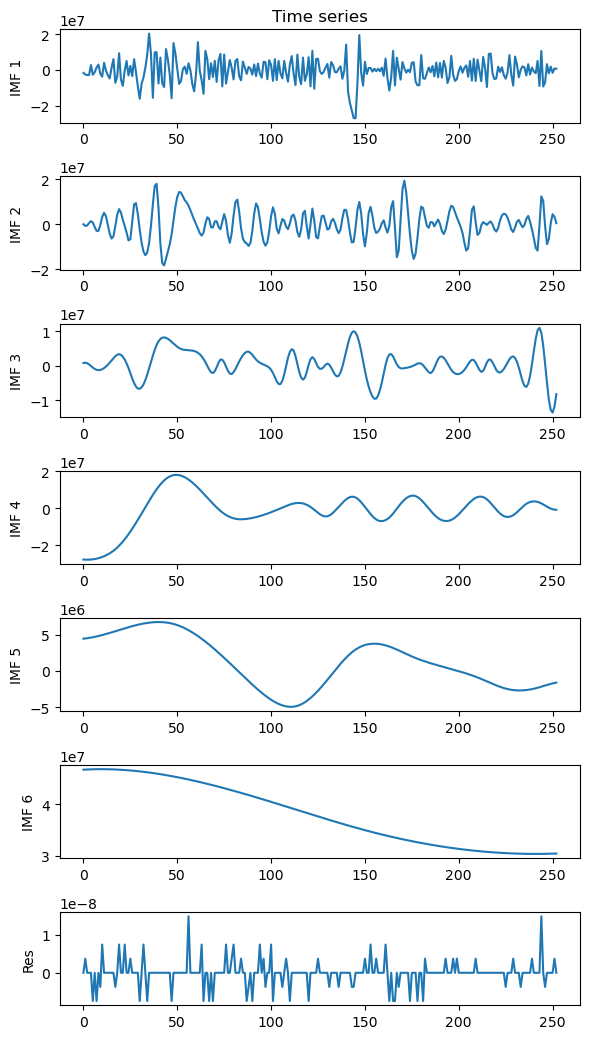

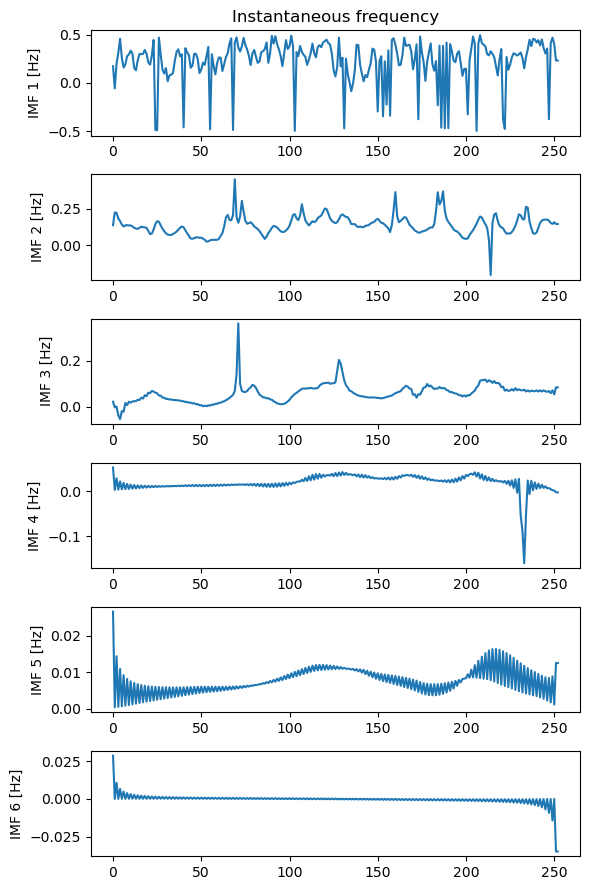

In [7]:
vis.show()

## Due to the mean, upper, lower spline calculations, the decomposition essentially normalizes itself.
## However, let's explore normalizing before and after.
## Note normalizing before would afford data leakage. Therefore, normalizing after is preferred. 

In [16]:
imfs, res = ceemdan_dict['MSFT']['Close'].get_imfs_and_residue()

imfs = minmax_scale(imfs.T).T
res = minmax_scale(res.T).T
#t = ticker_dataframe.reportperiod.dt.strftime("%m/%d/%Y").to_numpy()  
#t = ticker_dataframe.reportperiod.dt.date.to_numpy()  
t = np.arange(ticker_dataframe.reportperiod.shape[0])
# In general:
#components = EEMD()(S)
#imfs, res = components[:-1], components[-1]

vis = Visualisation()
vis.plot_imfs(imfs=imfs, residue=res, t=t, include_residue=True)
vis.plot_instant_freq(t, imfs=imfs)

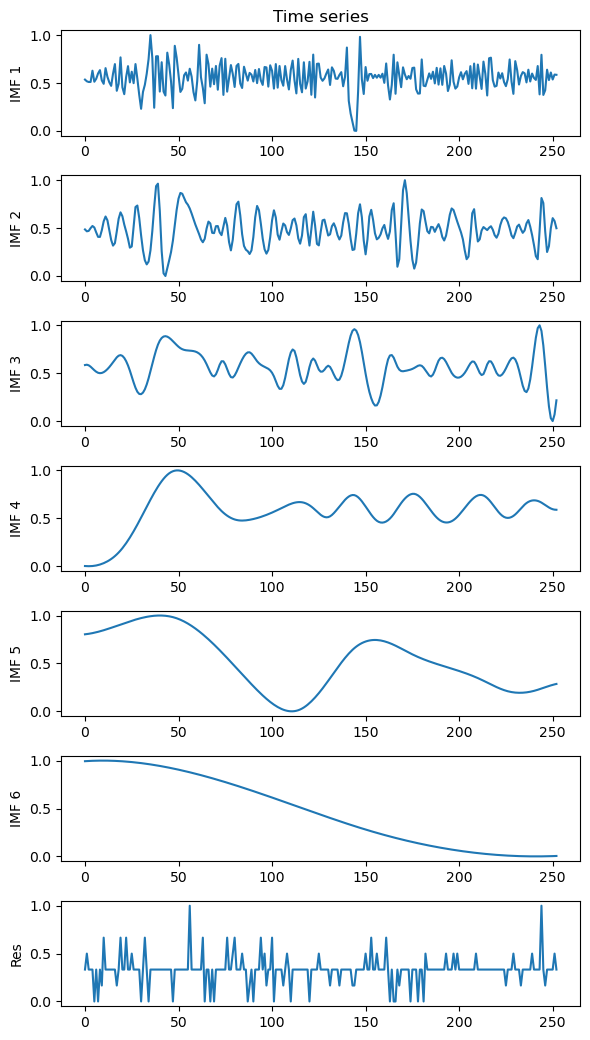

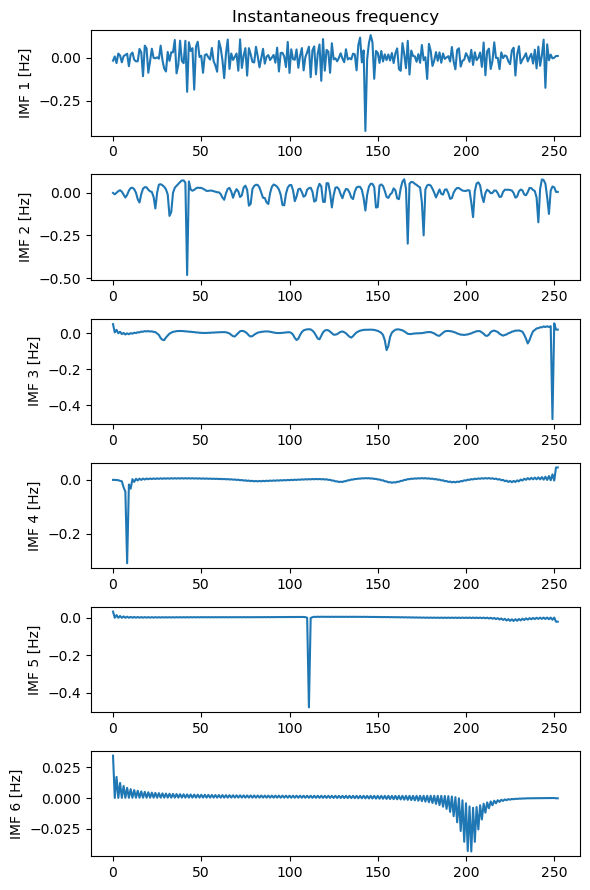

In [17]:
vis.show()

## What we notice is that the IMFs, our features, rescale nicely. 
## However, this transforms the Hz dramatically.

## It is worth noting that XGB would eliminate need for feature scaling. Target scaling would still be necessary.

# Next, let's review the localized Calculation by comparing a decomposition on the subset.
### I expect that the IMFs will not map exactly. Specifically the lower Hz, IMF3+, will not have the same long term information.

In [23]:
# decomposing
decomp_subset = {}
scalers = {}
ceemdan_dict_sub= {}
ceemdan = CEEMDAN(parallel=True, processes=10)

for ticker in ticker_dataframe.ticker.unique():
    print(f'[{ticker}] Decomposing...')
    decomp_subset[ticker] = {}
    scalers[ticker] = {}
    ceemdan_dict_sub[ticker] = {}
    
    #if logged:
    #    for c in coi[2:]:
    #        ticker_dataframe[c] = np.log(ticker_dataframe[c])
        
    for column in coi[2:]:  
        decomp_subset[ticker][column] ={}
        ceemdan_dict_sub[ticker][column] = {}      
        try:
            
            # Note about splitting
            # Due to CEEMDAN local calculation data leakage isn't an issue 
            # train / valid / test  
            TRAIN_VALID_RATIO = 0.25
            TRAIN_TEST_CUTOFF = ticker_dataframe.index[round(ticker_dataframe.shape[0] * TRAIN_VALID_RATIO)]
            train_valids_series = ticker_dataframe.loc[:TRAIN_TEST_CUTOFF][column].values.reshape(-1,1)


            #if standard:
            #    scaler = StandardScaler()
            #    scaler.fit(train_valids_series)
            #    scalers[ticker][column] = scaler
            
            #if minmax:
            #    scaler = MinMaxScaler()
            #    scaler.fit(train_valids_series)
            #    scalers[ticker][column] = scaler
            #print(f'[{ticker}][{column}] Scaling finished; next decomposition')
            
            # decompose
            ticker_feature_time_series = np.frombuffer(train_valids_series)
            ticker_feature_time_series_imfs = ceemdan(ticker_feature_time_series, max_imf=10)
            ceemdan_dict_sub[ticker][column] = ceemdan
            #print(ticker_feature_time_series_imfs)
            #print(f'[{ticker}][{column}] Decomposition finished; restructuring')
            
            # iterating every IMF 
            for i, imf_series in enumerate(ticker_feature_time_series_imfs):
                
                if i < len(ticker_feature_time_series_imfs)-1: # last one is residual
                    decomp_subset[ticker][column][f'IMF{i+1}'] = imf_series
                else:
                    decomp_subset[ticker][column][f'Rsd'] = imf_series
            print(f'Finished Decomposing [{ticker}][{column}]')
        except:
            print(f'ERROR ticker[{ticker}][{column}]')
            decomp_subset[ticker][column] = 'ERROR'
            ceemdan_dict_sub[ticker][column] = 'ERROR'
            
        finally:
            continue
        

[MSFT] Decomposing...
Finished Decomposing [MSFT][Open]
Finished Decomposing [MSFT][High]
Finished Decomposing [MSFT][Low]
Finished Decomposing [MSFT][Close]
Finished Decomposing [MSFT][Volume]


In [51]:
TRAIN_TEST_CUTOFF*2

2991858

In [20]:
TRAIN_VALID_RATIO = 0.25
TRAIN_TEST_CUTOFF = ticker_dataframe.index[round(ticker_dataframe.shape[0] * TRAIN_VALID_RATIO)]
ticker_dataframe.loc[:TRAIN_TEST_CUTOFF]['reportperiod']

1495992   2020-01-02
1495991   2020-01-03
1495990   2020-01-06
1495989   2020-01-07
1495988   2020-01-08
             ...    
1495933   2020-03-27
1495932   2020-03-30
1495931   2020-03-31
1495930   2020-04-01
1495929   2020-04-02
Name: reportperiod, Length: 64, dtype: datetime64[ns]

In [24]:
# Given the Length above this should be 64 as well
decomp_subset['MSFT']['Close']['IMF1'].shape

(64,)

In [25]:
# As expected IMF3+ are missing...
decomp_subset['MSFT']['Close'].keys()

dict_keys(['IMF1', 'IMF2', 'IMF3', 'Rsd'])

In [38]:
res.shape

(64,)

In [40]:
.shape

(253,)

In [48]:
imfs, res = ceemdan_dict_sub['MSFT']['Close'].get_imfs_and_residue()
#t = ticker_dataframe.reportperiod.dt.strftime("%m/%d/%Y").to_numpy()  
#t = ticker_dataframe.reportperiod.dt.date.to_numpy()

# padding so that plotting with same x-axis
ex = ticker_dataframe.reportperiod.shape[0]- decomp_subset['MSFT']['Close']['IMF1'].shape[0]
imfs = np.pad(imfs, [(0, 0),(0,ex)], 'edge') 
res = np.pad(res, (0,ex), 'edge') 
t = np.arange(ticker_dataframe.reportperiod.shape[0])
# In general:
#components = EEMD()(S)
#imfs, res = components[:-1], components[-1]

vis = Visualisation()
vis.plot_imfs(imfs=imfs, residue=res, t=t, include_residue=True)
vis.plot_instant_freq(t, imfs=imfs)

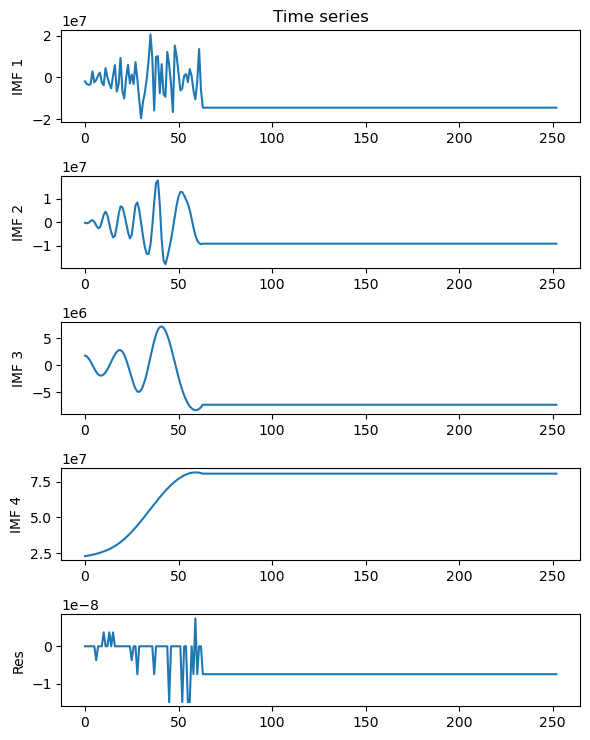

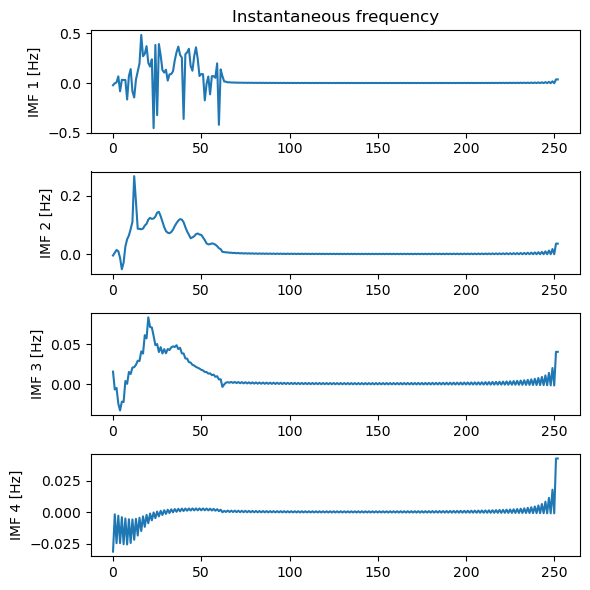

In [49]:
vis.show()

In [53]:
# repeating with a mid cut

# decomposing
decomp_subset = {}
scalers = {}
ceemdan_dict_sub= {}
ceemdan = CEEMDAN(parallel=True, processes=10)

for ticker in ticker_dataframe.ticker.unique():
    print(f'[{ticker}] Decomposing...')
    decomp_subset[ticker] = {}
    scalers[ticker] = {}
    ceemdan_dict_sub[ticker] = {}
    
    #if logged:
    #    for c in coi[2:]:
    #        ticker_dataframe[c] = np.log(ticker_dataframe[c])
        
    for column in coi[2:]:  
        decomp_subset[ticker][column] ={}
        ceemdan_dict_sub[ticker][column] = {}      
        try:
            
            # Note about splitting
            # Due to CEEMDAN local calculation data leakage isn't an issue 
            # train / valid / test  
            TRAIN_VALID_RATIO = 0.5
            TRAIN_VALID_RATIO_END = 0.75
            TRAIN_TEST_CUTOFF = ticker_dataframe.index[round(ticker_dataframe.shape[0] * TRAIN_VALID_RATIO)]
            TRAIN_TEST_END = ticker_dataframe.index[round(ticker_dataframe.shape[0] * TRAIN_VALID_RATIO_END)]
            train_valids_series = ticker_dataframe.loc[TRAIN_TEST_CUTOFF:TRAIN_TEST_END][column].values.reshape(-1,1)


            #if standard:
            #    scaler = StandardScaler()
            #    scaler.fit(train_valids_series)
            #    scalers[ticker][column] = scaler
            
            #if minmax:
            #    scaler = MinMaxScaler()
            #    scaler.fit(train_valids_series)
            #    scalers[ticker][column] = scaler
            #print(f'[{ticker}][{column}] Scaling finished; next decomposition')
            
            # decompose
            ticker_feature_time_series = np.frombuffer(train_valids_series)
            ticker_feature_time_series_imfs = ceemdan(ticker_feature_time_series, max_imf=10)
            ceemdan_dict_sub[ticker][column] = ceemdan
            #print(ticker_feature_time_series_imfs)
            #print(f'[{ticker}][{column}] Decomposition finished; restructuring')
            
            # iterating every IMF 
            for i, imf_series in enumerate(ticker_feature_time_series_imfs):
                
                if i < len(ticker_feature_time_series_imfs)-1: # last one is residual
                    decomp_subset[ticker][column][f'IMF{i+1}'] = imf_series
                else:
                    decomp_subset[ticker][column][f'Rsd'] = imf_series
            print(f'Finished Decomposing [{ticker}][{column}]')
        except:
            print(f'ERROR ticker[{ticker}][{column}]')
            decomp_subset[ticker][column] = 'ERROR'
            ceemdan_dict_sub[ticker][column] = 'ERROR'
            
        finally:
            continue
        

[MSFT] Decomposing...
Finished Decomposing [MSFT][Open]
Finished Decomposing [MSFT][High]
Finished Decomposing [MSFT][Low]
Finished Decomposing [MSFT][Close]
Finished Decomposing [MSFT][Volume]


In [63]:
imfs, res = ceemdan_dict_sub['MSFT']['Close'].get_imfs_and_residue()
np.pad(imfs, [(0, 0),(b4,a4)], 'edge').shape

(4, 255)

In [64]:
ticker_dataframe.loc[:TRAIN_TEST_CUTOFF]['Close']

1495992    160.619995
1495991    158.619995
1495990    159.029999
1495989    157.580002
1495988    160.089996
              ...    
1495870    196.330002
1495869    198.440002
1495868    203.509995
1495867    204.699997
1495866    206.259995
Name: Close, Length: 127, dtype: float64

In [66]:
ticker_dataframe.loc[TRAIN_TEST_CUTOFF+1:TRAIN_TEST_END]['Close']

1495866    206.259995
1495865    210.699997
1495864    208.250000
1495863    212.830002
1495862    214.320007
              ...    
1495806    209.440002
1495805    207.259995
1495804    210.330002
1495803    212.460007
1495802    206.190002
Name: Close, Length: 65, dtype: float64

In [67]:
ticker_dataframe.loc[TRAIN_TEST_END+1:]

,ticker,reportperiod,Open,High,Low,Close,Volume
1495802,MSFT,2020-10-02,208.000000,210.990005,205.539993,206.190002,33154800.0
1495801,MSFT,2020-10-05,207.220001,210.410004,206.979996,210.380005,21331600.0
1495800,MSFT,2020-10-06,208.820007,210.179993,204.820007,205.910004,28554300.0
1495799,MSFT,2020-10-07,207.059998,210.110001,206.720001,209.830002,25681100.0
1495798,MSFT,2020-10-08,210.509995,211.190002,208.320007,210.580002,19925800.0
...,...,...,...,...,...,...,...
1495744,MSFT,2020-12-24,221.419998,223.610001,221.199997,222.750000,10550600.0
1495743,MSFT,2020-12-28,224.449997,226.029999,223.020004,224.960007,17933500.0
1495742,MSFT,2020-12-29,226.309998,227.179993,223.580002,224.149994,17403200.0
1495741,MSFT,2020-12-30,225.229996,225.630005,221.470001,221.679993,20272300.0


In [77]:
imfs, res = ceemdan_dict_sub['MSFT']['Close'].get_imfs_and_residue()
#t = ticker_dataframe.reportperiod.dt.strftime("%m/%d/%Y").to_numpy()  
#t = ticker_dataframe.reportperiod.dt.date.to_numpy()

# padding so that plotting with same x-axis
TRAIN_VALID_RATIO = 0.5
TRAIN_VALID_RATIO_END = 0.75
TRAIN_TEST_CUTOFF = ticker_dataframe.index[round(ticker_dataframe.shape[0] * TRAIN_VALID_RATIO)] + 1
TRAIN_TEST_END = ticker_dataframe.index[round(ticker_dataframe.shape[0] * TRAIN_VALID_RATIO_END)] - 1
b4 = ticker_dataframe.loc[:TRAIN_TEST_CUTOFF]['Close'].shape[0]
a4 = ticker_dataframe.loc[TRAIN_TEST_END:]['Close'].shape[0]
imfs = np.pad(imfs, [(0, 0),(b4,a4)], 'edge') 
res = np.pad(res, (b4,a4), 'edge') 
t = np.arange(ticker_dataframe.reportperiod.shape[0])
# In general:
#components = EEMD()(S)
#imfs, res = components[:-1], components[-1]

vis = Visualisation()
vis.plot_imfs(imfs=imfs, residue=res, t=t, include_residue=True)
#vis.plot_instant_freq(t, imfs=imfs)

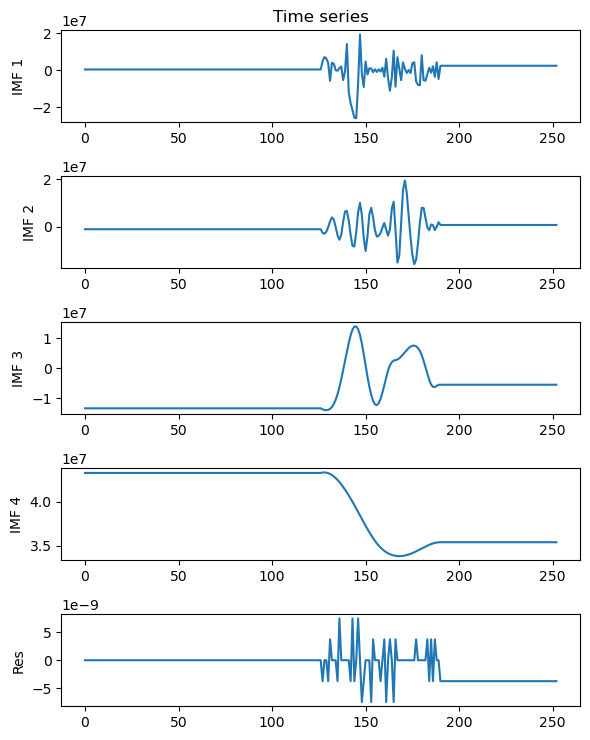

In [78]:
vis.show()

In [ ]:
## Notably, IMF1 & IMF2 are similar enough. 
## It is IMF3+ and the Residual that have noticeably different decompositions.
## This intuitively makes sense with the numerical accuracy scores in research – they only leverages IMF1-2 
## and then relied on spline calculations for the later IMFs